In [3]:
# 1. CORE DATA MANIPULATION
import pandas as pd           
import numpy as np          

# 2. DATA EXTRACTION & CLEANING
import re                     
from rapidfuzz import process, fuzz 

# 3. DATABASE INTEGRATION
from sqlalchemy import create_engine

# 4. VISUALIZATION
import matplotlib.pyplot as plt
import seaborn as sns          


In [9]:
# 2. DATA INGESTION
# Load the raw dataset
try:
    df_raw = pd.read_csv('raw.csv')
    print("Dataset loaded successfully.")
    
    # Initial inspection of the 'Submitted' layer
    print(f"\nTotal records ingested: {len(df_raw)}")
    print("\nFirst 5 rows of raw data:")
    display(df_raw.head())
    
    # Check for missing values and data types
    print("\nDataset Summary:")
    print(df_raw.info())

except FileNotFoundError:
    print("Error: The CSV file was not found. Please ensure the file name matches.")

Dataset loaded successfully.

Total records ingested: 56

First 5 rows of raw data:


,Category,Business_Name,Phone_Number,Address
0,Vet,Paws & Claws Veterinary Clinic,-9000012254,"12, Linking Rd, Bandra West, Mumbai, Maharasht..."
1,Vet,CityPet Multispeciality Vet Centre,9865626522,"44, MG Rd, Ashok Nagar, Bengaluru, Karnataka 5..."
2,Vet,GreenPaws Animal Hospital,-9000012256,"7, Safdarjung Enclave, New Delhi, Delhi 110029"
3,Vet,Happy Tails Vet Care,-9000012257,"19, Banjara Hills Rd No 12, Hyderabad, Telanga..."
4,Vet,Marina Pet Clinic,9000012349,"28, E Coast Rd, Besant Nagar, Chennai, Tamil N..."



Dataset Summary:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56 entries, 0 to 55
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Category       56 non-null     object
 1   Business_Name  56 non-null     object
 2   Phone_Number   56 non-null     object
 3   Address        56 non-null     object
dtypes: object(4)
memory usage: 1.9+ KB
None


In [10]:
# 3. DATA CLEANING & STANDARDIZATION
def standardize_phone(phone_str):
    if pd.isna(phone_str) or str(phone_str).strip() == "":
        return None
        
    # Use Regex to keep only numeric digits
    clean_digits = re.sub(r'\D', '', str(phone_str))
    
    # Standardize to exactly 10 digits and add prefix
    if len(clean_digits) >= 10:
        return f"+91{clean_digits[-10:]}"
    
    return None  # Records marked for 'Needs Fix' stage

# Apply the cleaner to the 'Phone_Number' column
df_raw['Cleaned_Phone'] = df_raw['Phone_Number'].apply(standardize_phone)

# Verification step: View raw vs. cleaned results
print("Phone Number Normalization Results:")
display(df_raw[['Business_Name', 'Phone_Number', 'Cleaned_Phone']].head(10))

Phone Number Normalization Results:


,Business_Name,Phone_Number,Cleaned_Phone
0,Paws & Claws Veterinary Clinic,-9000012254,+919000012254
1,CityPet Multispeciality Vet Centre,9865626522,+919865626522
2,GreenPaws Animal Hospital,-9000012256,+919000012256
3,Happy Tails Vet Care,-9000012257,+919000012257
4,Marina Pet Clinic,9000012349,+919000012349
5,Howrah Pet Wellness Clinic,-9000012259,+919000012259
6,Deccan Pet Polyclinic,90000-12351,+919000012351
7,Sabarmati Veterinary Care,-9000012261,+919000012261
8,PinkCity Pet Hospital,-9000012262,+919000012262
9,Gomti Nagar Pet Clinic,-9000012263,+919000012263


In [13]:
# 4. DEDUPLICATION & FINAL QUALITY AUDIT

# A. Exact Duplicate Detection (Based on Cleaned Phone & Business Name)
exact_dupes = df_raw[df_raw.duplicated(subset=['Cleaned_Phone', 'Business_Name'], keep='first')]
print(f"Exact duplicates found and flagged for removal: {len(exact_dupes)}")

# B. Identification of 'Red Flags' (As per Proposal Section 3.2)
# Flagging entries where the same phone is used for different business names
phone_conflicts = df_raw[df_raw.duplicated(subset=['Cleaned_Phone'], keep=False) & 
                         ~df_raw.duplicated(subset=['Cleaned_Phone', 'Business_Name'], keep=False)]

print(f"Phone conflicts (Same phone, different names) detected: {len(phone_conflicts)}")

# C. Removing Duplicates to Create the 'Ready' Dataset
df_ready = df_raw.drop_duplicates(subset=['Cleaned_Phone', 'Business_Name'], keep='first').reset_index(drop=True)

print(f"\nFinal record count for 'Ready for Verification' stage: {len(df_ready)}")
display(df_ready.tail(10)) # Check the end where you added duplicates

Exact duplicates found and flagged for removal: 6
Phone conflicts (Same phone, different names) detected: 0

Final record count for 'Ready for Verification' stage: 50


,Category,Business_Name,Phone_Number,Address,Cleaned_Phone,Flag_Invalid_Phone,Flag_Missing_Address,Flag_Duplicate_Phone
40,Boarding,Mumbai Cozy Paws Boarding,-9000012294,"8, Marol, Andheri East, Mumbai, Maharashtra 40...",+919000012294,False,False,True
41,Boarding,Delhi Pet Staycation,-9000012295,"51, Chhattarpur, New Delhi, Delhi 110074",+919000012295,False,False,False
42,Boarding,Bengaluru HomeAway Pet Boarding,-9000012296,"32, HSR Layout Sector 2, Bengaluru, Karnataka ...",+919000012296,False,False,False
43,Boarding,Hyderabad Wag & Stay Boarding,-9000012297,"20, Kondapur, Hyderabad, Telangana 500084",+919000012297,False,False,False
44,Boarding,Chennai PawPalace Boarding,-9000012298,"OMR, Perungudi, Chennai, Tamil Nadu 600096",+919000012298,False,False,False
45,Boarding,Kolkata Pet Inn Boarding,-9000012299,"45, New Town Action Area 1, Kolkata, West Beng...",+919000012299,False,False,False
46,Boarding,Pune Pet Resort & Boarding,-9000012300,"Baner Rd, Baner, Pune, Maharashtra 411045",+919000012300,False,False,True
47,Boarding,Ahmedabad FurLodge Boarding,-9000012301,"Prahlad Nagar, Ahmedabad, Gujarat 380015",+919000012301,False,False,False
48,Boarding,Jaipur Pet Guest House,-9000012302,"Sirsi Rd, Vaishali Extension, Jaipur, Rajastha...",+919000012302,False,False,False
49,Boarding,Lucknow Happy Kennels Boarding,-9000012303,"Faizabad Rd, Indira Nagar, Lucknow, Uttar Prad...",+919000012303,False,False,False


In [14]:
# 5. AUTOMATED RED FLAG AUDIT

# Flag 1: Invalid Phone Number (Less than 10 digits after cleaning)
df_raw['Flag_Invalid_Phone'] = df_raw['Cleaned_Phone'].isna()

# Flag 2: Missing Address (Incomplete Listing)
df_raw['Flag_Missing_Address'] = df_raw['Address'].isna() | (df_raw['Address'] == "")

# Flag 3: Potential Duplicate (Based on identical cleaned phone numbers)
df_raw['Flag_Duplicate_Phone'] = df_raw.duplicated(subset=['Cleaned_Phone'], keep=False) & df_raw['Cleaned_Phone'].notna()

# Summary of Audit
audit_summary = {
    "Total Records": len(df_raw),
    "Invalid Phones": df_raw['Flag_Invalid_Phone'].sum(),
    "Missing Addresses": df_raw['Flag_Missing_Address'].sum(),
    "Phone Duplicates": df_raw['Flag_Duplicate_Phone'].sum()
}

print("System Audit Summary:")
for key, value in audit_summary.items():
    print(f"- {key}: {value}")

System Audit Summary:
- Total Records: 56
- Invalid Phones: 0
- Missing Addresses: 0
- Phone Duplicates: 12


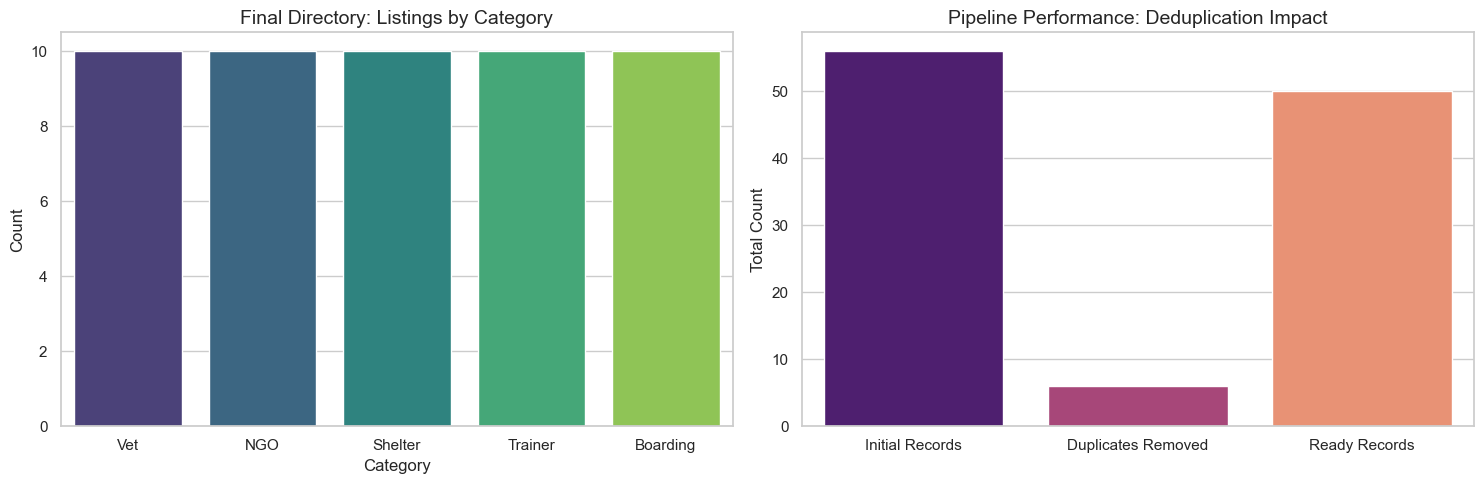

In [16]:
# 6. DATA QUALITY DASHBOARD
import matplotlib.pyplot as plt
import seaborn as sns

# Set visual style
sns.set_theme(style="whitegrid")
plt.figure(figsize=(15, 5))

# Visualization 1: Record Breakdown by Category
plt.subplot(1, 2, 1)
category_counts = df_ready['Category'].value_counts()
sns.barplot(x=category_counts.index, y=category_counts.values, hue=category_counts.index, palette="viridis", legend=False)
plt.title('Final Directory: Listings by Category', fontsize=14)
plt.ylabel('Count')

# Visualization 2: Cleaning Impact (Audit Summary)
plt.subplot(1, 2, 2)
audit_labels = ['Initial Records', 'Duplicates Removed', 'Ready Records']
audit_values = [len(df_raw), len(exact_dupes), len(df_ready)]
sns.barplot(x=audit_labels, y=audit_values, hue=audit_labels, palette="magma", legend=False)
plt.title('Pipeline Performance: Deduplication Impact', fontsize=14)
plt.ylabel('Total Count')

plt.tight_layout()
plt.show()

In [17]:
# 7. FINAL EXPORT TO STRUCTURED DIRECTORY
# Mark status as 'Ready' for the verification team as per Section 2.2 of proposal
df_ready['verification_status'] = 'Ready'

# Save the cleaned dataset for GitHub/Submission
df_ready.to_csv('uday_dokania_verified_directory.csv', index=False)
print("Final 'Ready' dataset exported successfully.")

Final 'Ready' dataset exported successfully.
